## Trends and Seasonality in Avocado Sales

In May 2017, Australian millionaire Tim Gurner stated on an episode of 60 Minutes that "When [he] was trying to buy [his] first home, [he] wasn't buying smashed avocado for \\$19 and four coffees at $4 each" [1]. People on social media platforms mocked him for this statement, and his statement has since become a meme [2].

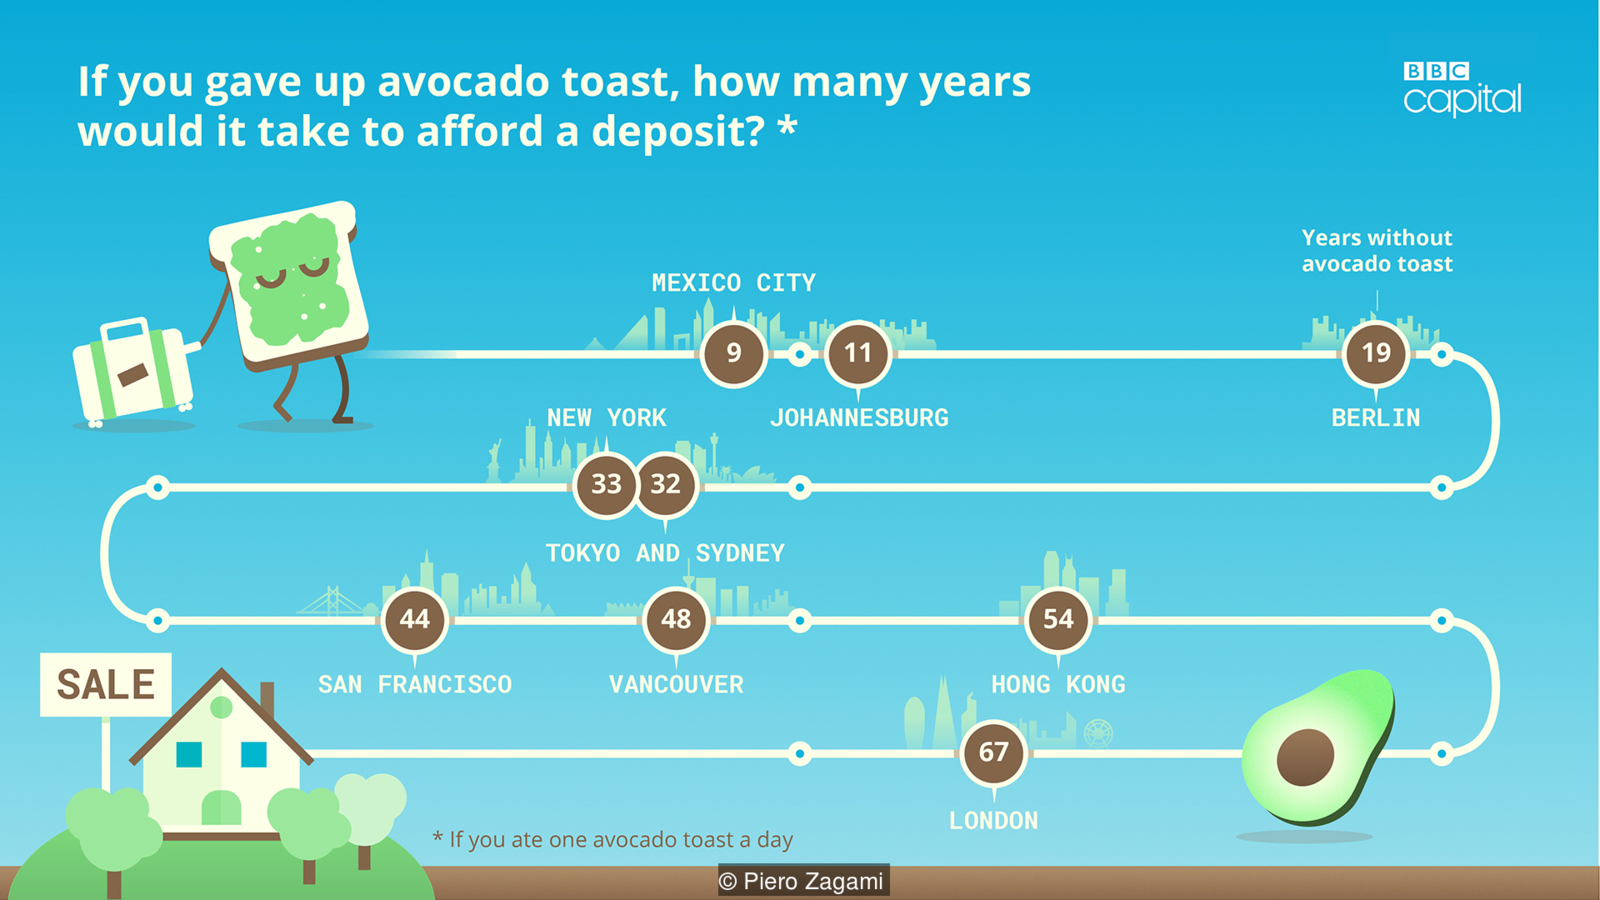

In this notebook, we analyze avocado sales data provided by the Hass Avocado Board [3] to determine whether avocado sales have increased as a result of this social media event. (Remark: As of 4/17/2019, the data provided by the Hass Avocado Board is no longer available in the version we analyze below).

[1] https://www.theguardian.com/lifeandstyle/2017/may/15/australian-millionaire-millennials-avocado-toast-house <br>
[2] https://knowyourmeme.com/memes/avocado-toast <br>
[3] https://hassavocadoboard.com/ 

In [1]:
#Import relevant packages.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from pylab import rcParams
import itertools

plt.style.use('fivethirtyeight')
%matplotlib inline

Before I open the data in Python, I usually explore the data a bit in Excel (force of habit from working in the finance industry :P). I noticed two things: 
<br> <br>
1) Data for 2014 is incomplete: data from 9 November 2014 through 28 December 2014 is missing from the dataset. We'll explore the data a bit first before deciding how we want to take care of these missing values. 
<br>
2) Data for 2014 is structured differently: the columns in this dataset was named differently than for 2015 through 2018, and the data concerning bag sizes was missing too. I renamed and reorganized the columns for 2014 to be consistent and save myself a little bit of coding.
<br>
3) Data for 2018 is incomplete: data from 9 December 2018 through 30 December 2018 is missing. Again, we'll explore the data first.
<br><br>
With that in mind, we're ready to start EDA.

In [2]:
#Read the data. We were able to save avocado sales data from January 2015 through November 2018. December 2018 data
#includes only the first week.
dataset14 = pd.read_excel(io = r"C:\Users\Patrick\Desktop\Avocados\2014.xls")
dataset15 = pd.read_excel(io = r"C:\Users\Patrick\Desktop\Avocados\2015.xls")
dataset16 = pd.read_excel(io = r"C:\Users\Patrick\Desktop\Avocados\2016.xls")
dataset17 = pd.read_excel(io = r"C:\Users\Patrick\Desktop\Avocados\2017.xls")
dataset18 = pd.read_excel(io = r"C:\Users\Patrick\Desktop\Avocados\2018.xls")

#Combine the yearly datasets into one. Ignore index to restart the indices. Since 2014 is missing sales data for
#Small Bags, Large Bags, and XLarge Bags, we set sort = False to ignore the warning.
dataset = pd.concat(objs = [dataset14, dataset15, dataset16, dataset17, dataset18]
                    , ignore_index = True
                    , sort = False)

#Look at a sample of the data.
dataset.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
0,2014-01-05 00:00:00,1.01,27761408.0,10535645.0,13905103.0,510274.0,2810386.0,NaN,NaN,NaN
1,2014-01-12 00:00:00,1.07,23985698.0,9647200.0,11187901.0,435843.0,2714754.0,NaN,NaN,NaN
2,2014-01-19 00:00:00,1.05,26883222.0,11227324.0,11576636.0,479435.0,3599827.0,NaN,NaN,NaN
3,2014-01-26 00:00:00,1.08,25625334.0,10750805.0,11138454.0,418538.0,3317537.0,NaN,NaN,NaN
4,2014-02-02 00:00:00,0.91,40210566.0,16680906.0,17812656.0,896612.0,4820392.0,NaN,NaN,NaN


The 2014 data for bag sizes returned NaN; this was to be expected.
<br><br>
Our data is evaluated weekly and always on a Sunday. Throughout this notebook, we assume that total volume is sales between Sunday through Saturday. For example, for 2014-01-05, the total volume is 27,761,408. We interpret this to mean that 27,761,408 units were sold from 5 January 2014(Sunday) through 11 January 2014 (Saturday). Other interpretations are possible, but we don't believe this will have a significant impact on our analysis.
<br><br>
Note that 4046, 4225, and 4770 do not add up to Total Volume. This is because Total Volume includes all avocado types, whereas the PLUs above are only for Hass avocados. Because we're interested in retail sales of all avocado types, and because we're not interested in what size bag avocados were sold, we drop the PLU and bag columns.

In [3]:
#Drop columns not used for analysis.
to_drop = [4046, 4225, 4770, 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
dataset = dataset.drop(labels = to_drop, axis = 1)

#Look at the data types.
dataset.dtypes

Date             object
AveragePrice    float64
Total Volume    float64
dtype: object

In [4]:
#Convert the "Date" column to a datetime object type.
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values(by = 'Date')
dataset.head()

,Date,AveragePrice,Total Volume
0,2014-01-05,1.01,27761408.0
1,2014-01-12,1.07,23985698.0
2,2014-01-19,1.05,26883222.0
3,2014-01-26,1.08,25625334.0
4,2014-02-02,0.91,40210566.0


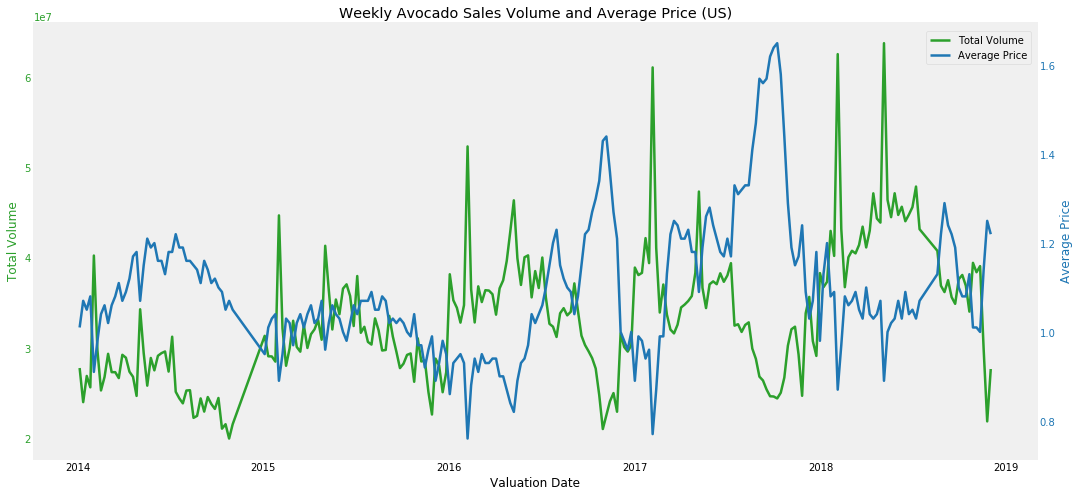

In [5]:
#Plot the weekly price and volume sales.

fig, ax1 = plt.subplots(figsize = (16, 8))

x = dataset['Date']
y1 = dataset['Total Volume']
y2 = dataset['AveragePrice']

#Plot the volume data (green).
color = 'tab:green'
ax1.set_xlabel('Valuation Date')
ax1.set_ylabel('Total Volume', color = color)
ax1.plot(x, y1, color = color, linewidth = 2.5, label = 'Total Volume')
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.grid(False)

ax2 = ax1.twinx()

#Plot the price data (blue).
color = 'tab:blue'
ax2.set_ylabel('Average Price', color = color)
ax2.plot(x, y2, color = color, linewidth = 2.5, label = 'Average Price')
ax2.tick_params(axis = 'y', labelcolor = color)
ax2.grid(False)

#Place the legend at the top-right corner of the plot.
fig.legend(loc = 1, bbox_transform=fig.transFigure, bbox_to_anchor = (0.95, 0.875))
#Cool title.
plt.title(label = 'Weekly Avocado Sales Volume and Average Price (US)')

#Plot!
plt.show()

The graph looks strange from 2014 entering 2015. This is because of the missing data from 9 November 2014 through 28 December 2014. We also appear to be missing data for right before 2019. Again, this was all to be expected. If we did not explore the data first in Excel, we definitely would've gone back to explore at this point.
<br><br>
We also notice that sales volume and price appear inversely proportional. This is to be expected: if prices are low, then sales are high and vice-versa.
<br><br>
Let's try to smooth the data by converting to monthly data.

In [6]:
#Create a function that computes the end of the month of a given date.
def GetEndOfMonth(input_date):
    """
    Given a date, return the end of the month for that date.
    """
    end_day = input_date.days_in_month
    end_month = input_date.month
    end_year = input_date.year
    EndOfMonth = dt.date(day = end_day, month = end_month, year = end_year)
    return pd.to_datetime(EndOfMonth)

In [7]:
#Get the end of the month for the valuation date.
dataset['EndOfMonth'] = dataset['Date'].apply(GetEndOfMonth)
#Get the end of next month for the valuation date.
dataset['EndOfNextMonth'] = dataset['EndOfMonth'].apply(lambda x: GetEndOfMonth(x + pd.DateOffset(days = 1)))

#Calculate how many days of the week are from the current month. This number will always be at least one.
dataset['Weight_Current'] = dataset['Date'].apply(lambda x: min(dt.timedelta(days = x.day).days, 7))
#Calculate how many days of the week are from the next month. This number can be zero.
dataset['Weight_Next'] = 7 - dataset['Weight_Current']

#Estimate the week's avocado sales that were from the current month.
dataset['Volume_Current'] = dataset['Total Volume'] * dataset['Weight_Current'] / 7
#Estimate the week's avocado sales that were from the next month.
dataset['Volume_Next'] = dataset['Total Volume'] * dataset['Weight_Next'] / 7 

#Drop columns that won't be used for future analysis.
to_drop = ['Date', 'Weight_Current', 'Weight_Next', 'Total Volume', 'AveragePrice']
dataset = dataset.drop(to_drop, axis = 1)

#Look at a sample of the data for a sanity check.
dataset.head()

,EndOfMonth,EndOfNextMonth,Volume_Current,Volume_Next
0,2014-01-31,2014-02-28,1.982958e+07,7.931831e+06
1,2014-01-31,2014-02-28,2.398570e+07,0.000000e+00
2,2014-01-31,2014-02-28,2.688322e+07,0.000000e+00
3,2014-01-31,2014-02-28,2.562533e+07,0.000000e+00
4,2014-02-28,2014-03-31,1.148873e+07,2.872183e+07


In [8]:
#Initialize the time series.
ts = pd.date_range(start = '1/31/2014', 
                   end = '12/31/2018', 
                   freq = 'M')
ts_dates = [[ValuationDate.month, ValuationDate.day] for ValuationDate in ts]
ts = pd.DataFrame(data = ts_dates, 
                  columns = ['Month', 'Days'], 
                  index = ts)

#Estimate volume sales for each month.
for ValuationDate in ts.index.values:
    current_sales = dataset.loc[dataset.EndOfMonth == ValuationDate, 'Volume_Current'].sum()
    next_sales = dataset.loc[dataset.EndOfNextMonth == ValuationDate, 'Volume_Next'].sum()
    ts.loc[ValuationDate, 'Volume'] = current_sales + next_sales

#Interpolate missing values
ts.loc[pd.to_datetime(['2014-11-30', '2014-12-31', '2018-12-31']), 'Volume'] = np.nan
ts['Volume'] = ts.assign(InterpolateTime=ts.Volume.interpolate(method='time'))['InterpolateTime']

#Get rid of variance of sales due to number of days in a month by calculating average daily sales instead.
ts['AveDailyVol'] = ts['Volume'] / ts['Days']
#The numbers are relatively large; it may be helpful to take the natural log of the data.
ts['logAveDailyVol'] = np.log(ts['AveDailyVol'])

#Sanity check.
ts

,Month,Days,Volume,AveDailyVol,logAveDailyVol
2014-01-31,1,31,9.632383e+07,3.107220e+06,14.949239
2014-02-28,2,28,1.011903e+08,3.613938e+06,15.100309
2014-03-31,3,31,1.475830e+08,4.760742e+06,15.375914
2014-04-30,4,30,1.245511e+08,4.151703e+06,15.239029
2014-05-31,5,31,1.078090e+08,3.477710e+06,15.061885
2014-06-30,6,30,1.341009e+08,4.470029e+06,15.312905
2014-07-31,7,31,1.237352e+08,3.991458e+06,15.199667
2014-08-31,8,31,1.097085e+08,3.538983e+06,15.079350
2014-09-30,9,30,1.089463e+08,3.631543e+06,15.105168
2014-10-31,10,31,8.001048e+07,2.580983e+06,14.763681


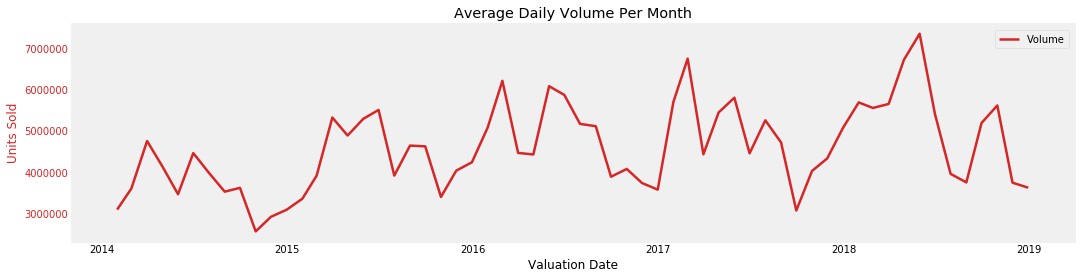

In [9]:
#Plot the average daily sales by month.

fig, ax = plt.subplots(figsize = (16, 4))

x = pd.to_datetime(ts.index.values)
y = ts['AveDailyVol']

color = 'tab:red'
ax.set_xlabel('Valuation Date')
ax.set_ylabel('Units Sold', color = color)
ax.plot(x, y, color = color, linewidth = 2.5, label = 'Volume')
ax.tick_params(axis = 'y', labelcolor = color)
ax.grid(False)

ax2 = ax1.twinx()

fig.legend(loc = 1, bbox_transform=fig.transFigure, bbox_to_anchor = (0.95, 0.875))
plt.title(label = 'Average Daily Volume Per Month')
plt.show()

Our data shows some seasonality: <br>
1) Sales appear high near the beginning and near the middle of each year. <br>
2) Sales appear low after the middle of the year and at the end of each year... <br>
3) Except for 2017. This year seems to have experienced very high sales. at the end of the year and at the start of 2018 that continued into the middle of 2018. <br><br>

Let's look at a breakdown of sales by month.

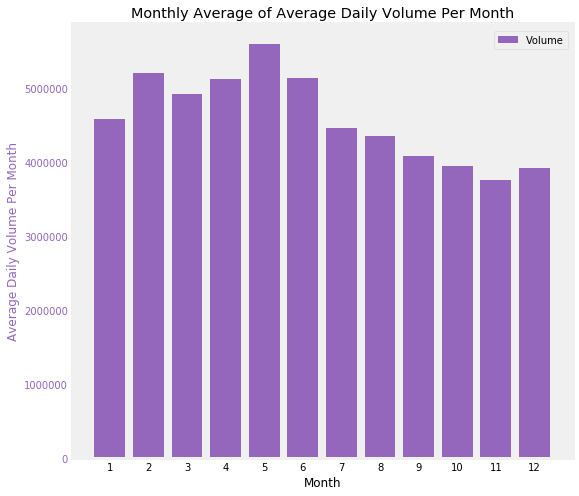

In [10]:
pvt = pd.pivot_table(data = ts
                     , values = 'AveDailyVol'
                     , index = 'Month'
                     , aggfunc = np.mean)

fig, ax = plt.subplots(figsize = (8, 8))

x = range(1, 13)
y = pvt['AveDailyVol']

color = 'tab:purple'
ax.set_xlabel('Month')
ax.set_ylabel('Average Daily Volume Per Month', color = color)
ax.bar(x, y, color = color, linewidth = 2.5, label = 'Volume')
ax.tick_params(axis = 'y', labelcolor = color)
ax.set_xticks(x)
ax.grid(False)

fig.legend(loc = 1, bbox_transform=fig.transFigure, bbox_to_anchor = (0.95, 0.875))
plt.title(label = 'Monthly Average of Average Daily Volume Per Month')
plt.show()

On average, sales are highest in February and May, and sales are lowest in October, November, and December. If not for 2017, November and December sales would be even lower. <br><br>

Let's decompose the time series. Since seasonal variation appears to increase with time, we'll model our series with a multiplicative model.

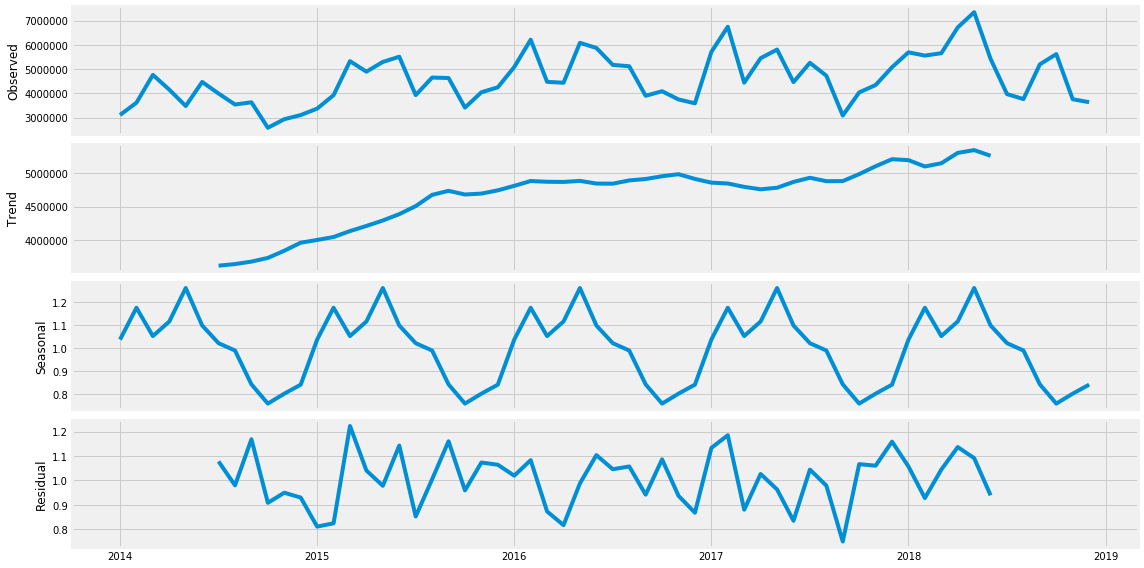

In [11]:
rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(ts['AveDailyVol'], model = 'multiplicative')
fig = decomposition.plot()
plt.show()

In [12]:
y = ts.loc[(ts.index <= pd.datetime(2017, 4, 30)), 'logAveDailyVol']

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ranked_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog = y
                                            , order = param
                                            , seasonal_order = param_seasonal
                                            , enforce_stationarity = True
                                            , enforce_invertibility = False)
            results = mod.fit()
            ranked_aic.append([results.aic, param, param_seasonal])
        except:
            continue       

ranked_aic = pd.DataFrame(data = ranked_aic, columns = ['aic', 'parameters', 'seasonal parameters'])
ranked_aic = ranked_aic.sort_values(by = 'aic', ascending = True).reset_index(drop = True)
ranked_aic

c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\programs\python\python37-32\lib\sit

c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\patrick\appdata\local\progr

,aic,parameters,seasonal parameters
0,-26.713788,"(2, 1, 2)","(1, 0, 0, 12)"
1,-25.410225,"(2, 1, 2)","(2, 0, 0, 12)"
2,-23.448486,"(0, 1, 2)","(1, 0, 0, 12)"
3,-23.371862,"(2, 1, 2)","(2, 0, 1, 12)"
4,-23.200599,"(0, 1, 2)","(2, 0, 0, 12)"
5,-22.434820,"(1, 1, 2)","(1, 0, 0, 12)"
6,-22.262421,"(2, 1, 1)","(1, 0, 0, 12)"
7,-22.143835,"(2, 1, 2)","(0, 0, 0, 12)"
8,-21.445274,"(0, 1, 2)","(2, 0, 1, 12)"
9,-21.352970,"(1, 1, 2)","(2, 0, 0, 12)"


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3324      0.537     -0.619      0.536      -1.384       0.719
ar.L2         -0.2892      0.266     -1.089      0.276      -0.810       0.231
ma.L1         -0.2863   1200.863     -0.000      1.000   -2353.935    2353.363
ma.L2         -0.7138    856.940     -0.001      0.999   -1680.285    1678.857
ar.S.L12       0.4602      0.255      1.808      0.071      -0.039       0.959
sigma2         0.0173     20.744      0.001      0.999     -40.640      40.674


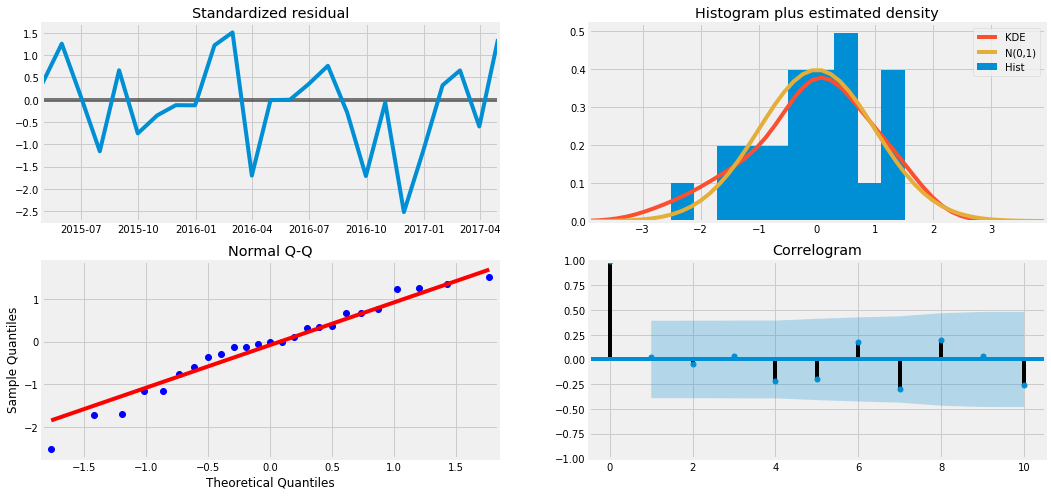

c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.923     -0.266      0.790      -2.056       1.564
ar.L2         -0.3580      0.473     -0.757      0.449      -1.285       0.569
ma.L1          1.0686    299.428      0.004      0.997    -585.799     587.937
ma.L2          0.0691     19.821      0.003      0.997     -38.780      38.918
ar.S.L12       0.6609      0.215      3.074      0.002       0.240       1.082
ar.S.L24      -0.5937      0.201     -2.958      0.003      -0.987      -0.200
sigma2         0.0138      4.153      0.003      0.997      -8.125       8.153


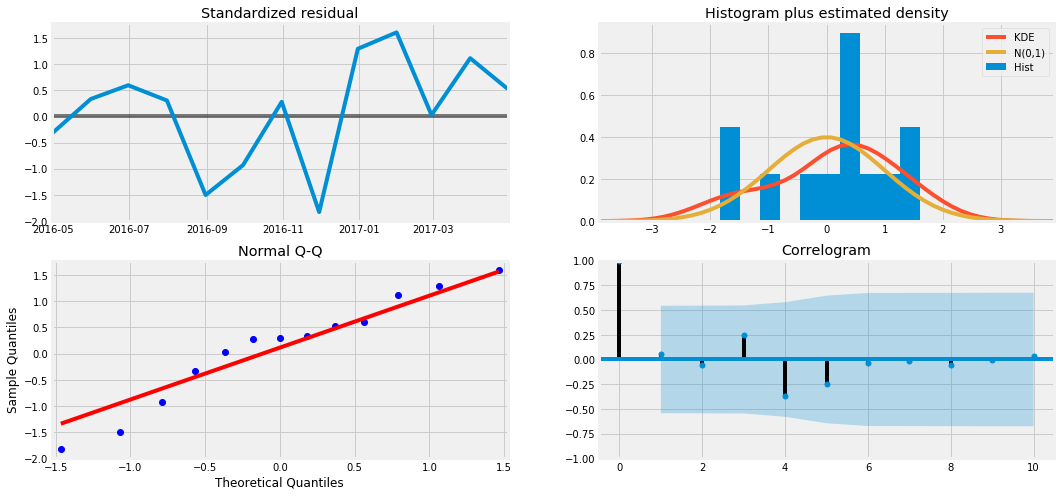

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3084   1272.872     -0.000      1.000   -2495.092    2494.475
ma.L2         -0.6916    880.319     -0.001      0.999   -1726.085    1724.701
ar.S.L12       0.5068      0.191      2.655      0.008       0.133       0.881
sigma2         0.0201     25.584      0.001      0.999     -50.124      50.164


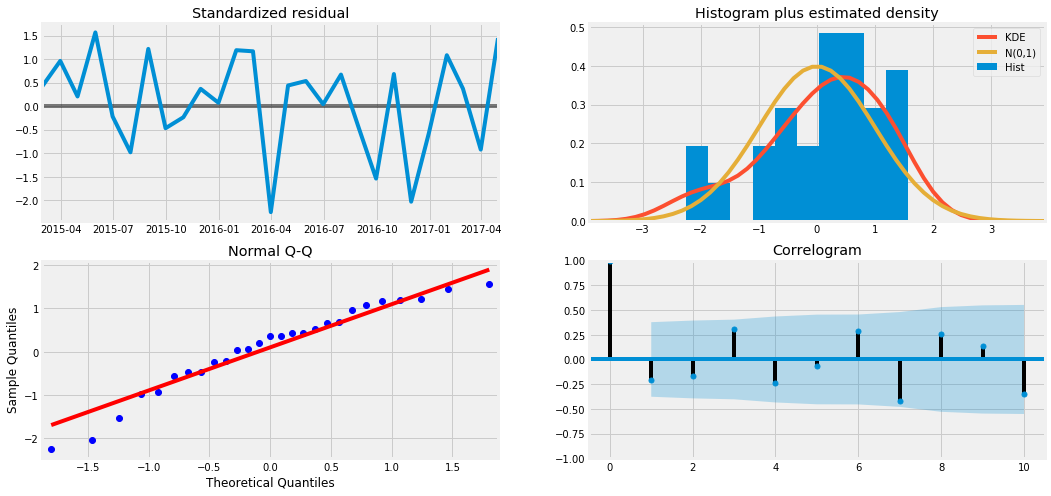

c:\users\patrick\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6922      0.591     -1.172      0.241      -1.850       0.465
ar.L2         -0.4149      0.358     -1.159      0.247      -1.117       0.287
ma.L1          1.9562    127.496      0.015      0.988    -247.932     251.845
ma.L2          0.9920    128.411      0.008      0.994    -250.690     252.674
ar.S.L12       0.7762      0.299      2.595      0.009       0.190       1.362
ar.S.L24      -0.6556      0.395     -1.662      0.097      -1.429       0.118
ma.S.L12      -1.0741     82.389     -0.013      0.990    -162.553     160.404
sigma2         0.0045      0.937      0.005      0.996      -1.831       1.840


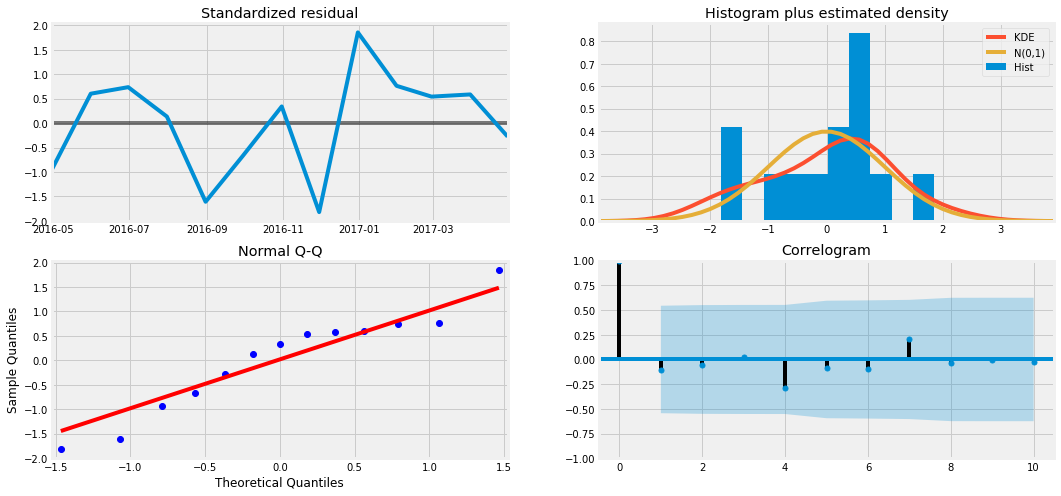

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1309    874.113      0.000      1.000   -1713.098    1713.360
ma.L2         -1.1310    987.725     -0.001      0.999   -1937.036    1934.774
ar.S.L12       0.6273      0.530      1.185      0.236      -0.411       1.665
ar.S.L24      -0.4832      0.740     -0.653      0.514      -1.934       0.967
sigma2         0.0175     15.306      0.001      0.999     -29.982      30.017


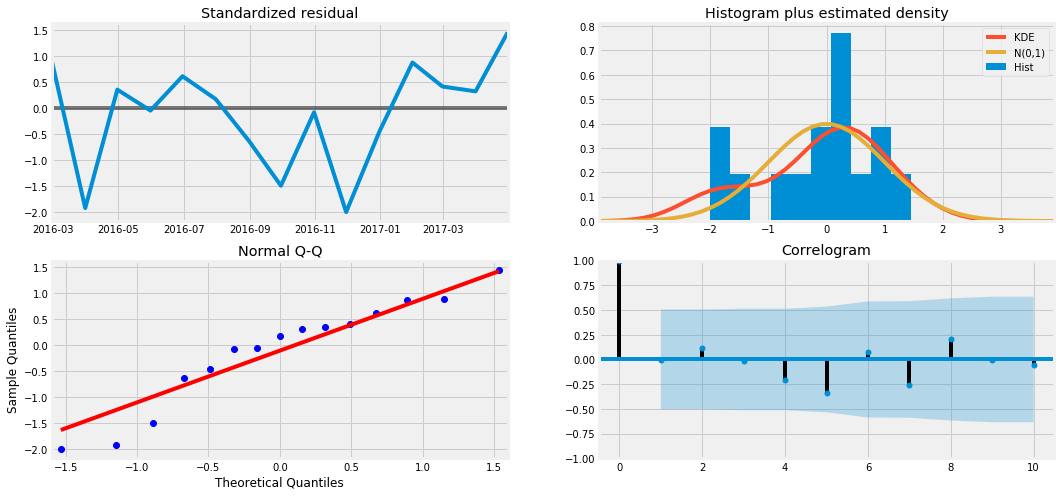

In [13]:
for i in range (0, 5):
    try:
        param = ranked_aic.loc[i, 'parameters']
        param_seasonal = ranked_aic.loc[i, 'seasonal parameters']
        mod = sm.tsa.statespace.SARIMAX(y,
                                        order = param,
                                        seasonal_order = param_seasonal,
                                        enforce_stationarity = False,
                                        enforce_invertibility = False)
        results = mod.fit()
        print(results.summary().tables[1])
        results.plot_diagnostics()
        plt.show()
    except:
        continue

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3324      0.537     -0.619      0.536      -1.384       0.719
ar.L2         -0.2892      0.266     -1.089      0.276      -0.810       0.231
ma.L1         -0.2863   1200.863     -0.000      1.000   -2353.935    2353.363
ma.L2         -0.7138    856.940     -0.001      0.999   -1680.285    1678.857
ar.S.L12       0.4602      0.255      1.808      0.071      -0.039       0.959
sigma2         0.0173     20.744      0.001      0.999     -40.640      40.674


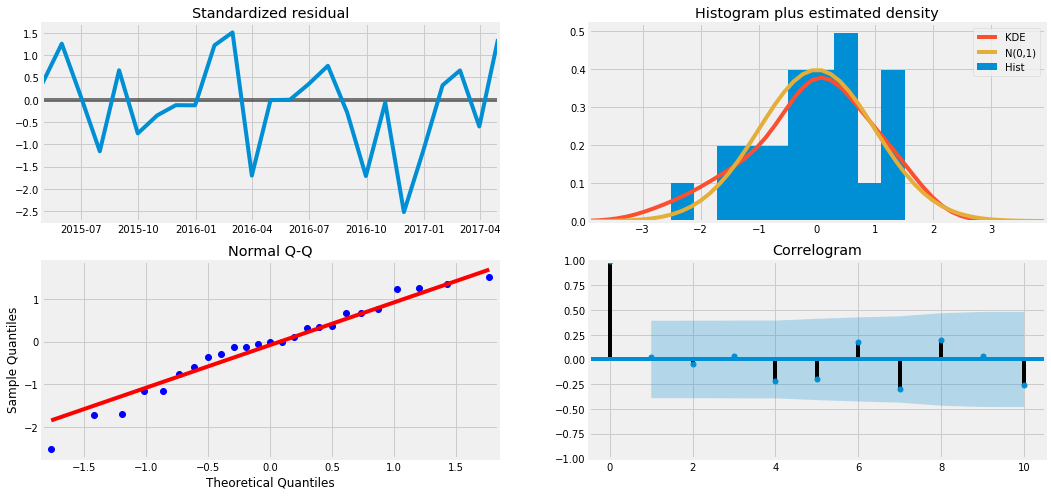

In [14]:
param = ranked_aic.loc[0, 'parameters']
param_seasonal = ranked_aic.loc[0, 'seasonal parameters']
mod = sm.tsa.statespace.SARIMAX(endog = y,
                                order = param,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics()
plt.show()

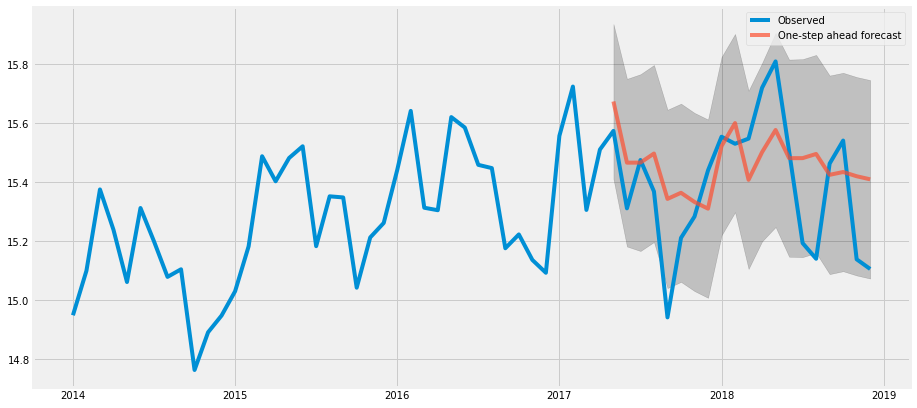

In [15]:
pred = results.get_prediction(start = pd.to_datetime('2017-05-31'),
                              end = pd.to_datetime('2018-12-31'),
                              dynamic = False)
pred_ci = pred.conf_int()

ax = ts['logAveDailyVol'].plot(label = 'Observed')

pred.predicted_mean.plot(ax = ax,
                        label = 'One-step ahead forecast',
                        alpha = .7,
                        figsize = (14, 7))


ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


plt.legend()
plt.show()